In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
import pysm3
import pysm3.units as u
# uses the CAMB cosmology which produced the cls
import camb
from cosmology import Cosmology
import glass
import glass.ext.camb


Simulate Synchrotron radiation using PYSM

In [3]:
def simulate_planck_maps(nside, freqs):
    """
    Simulate foreground emission and noise at different Planck frequencies.
    
    Parameters:
    nside (int): Healpix resolution parameter.
    
    Returns:
    tuple: Numpy arrays of simulated maps for synchrotron and free-free
    """    
    sens = np.array([150.,  162.,  210.,  77.4,  33.,  46.8, 154,  42.,  5016.])
    
    # Initialize PySM sky models for different foregrounds and CMB
    sky_s = pysm3.Sky(nside, preset_strings=["s1"])
    sky_f = pysm3.Sky(nside, preset_strings=["f1"])
    
    # Initialize storage for maps
    sync= []
    ff=[]
    # noise=[]
    for nf, freq in enumerate(freqs):
        # Generate noise
        # noise_pl = np.random.normal(size=(12 * nside**2)) * sens[nf] / hp.nside2resol(nside, True)
        # noise.append(noise_pl)
        
        # Convert emissions to uK_CMB
        conversion = u.K_RJ.to(u.K_CMB, equivalencies=u.cmb_equivalencies(freq * u.MHz))
        
        sync.append(sky_s.get_emission(freq * u.MHz)[0] * conversion)
        ff.append(sky_f.get_emission(freq * u.GHz)[0] * conversion)
        
    
    # Convert lists to numpy arrays (N_freq, N_pixels)
    return  np.array(sync), np.array(ff)


In [2]:
nside=256
freqs=np.arange(544,1088,step=1)
nfreqs=len(freqs)
lmax=3*nside -1

# creating a numpy random number generator for sampling
rng = np.random.default_rng(seed=42)

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)

In [5]:
sync,ff=simulate_planck_maps(nside, freqs)
print(sync.shape)

(544, 786432)


In [17]:
cl_sync=np.zeros((nfreqs, lmax+1))
cl_ff=np.zeros((nfreqs, lmax+1))
# calculate the angular power spectrum for synchrotron and free-free
for nf in range (nfreqs):
    cl_sync[nf]= hp.anafast(sync[nf])
    cl_ff[nf]= hp.anafast(ff[nf])

In [18]:
print(cl_sync.shape)

(544, 768)


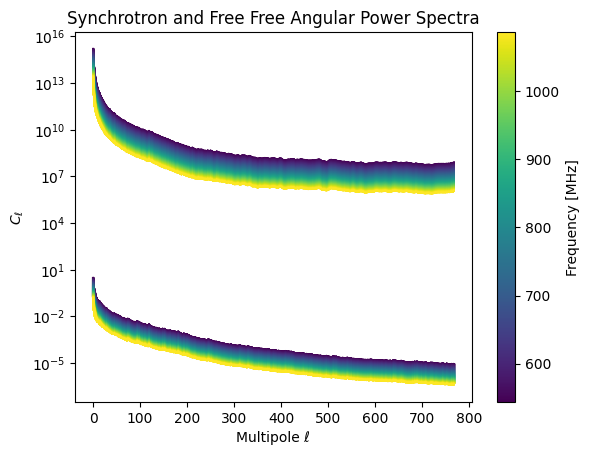

In [6]:
# Normalize for colormap
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(freqs.min(), freqs.max())

fig, ax = plt.subplots()

for i, f in enumerate(freqs):
    cl_sync = hp.anafast(sync[i, :])
    ax.plot(cl_sync, color=cmap(norm(f)))
    cl_ff = hp.anafast(ff[i, :])
    ax.plot(cl_ff, color=cmap(norm(f)))

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy for older matplotlib versions
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Frequency [MHz]')

ax.set_yscale('log')
ax.set_xlabel('Multipole ℓ')
ax.set_ylabel(r'$C_\ell$')
ax.set_title('Synchrotron and Free Free Angular Power Spectra')

plt.show()

NameError: name 'ff' is not defined

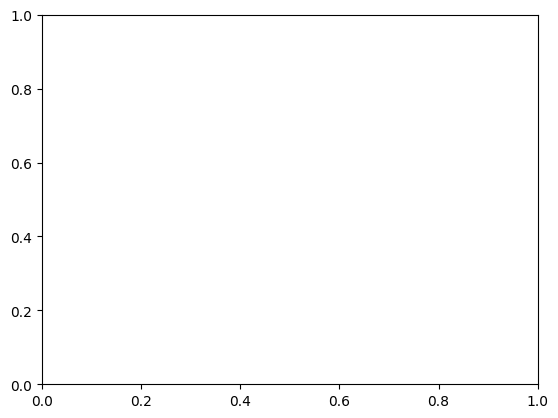

In [28]:
# Normalize for colormap
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(freqs.min(), freqs.max())

fig, ax = plt.subplots()

for i, f in enumerate(freqs):
    cl_ff = hp.anafast(ff[i, :])
    ax.plot(cl_ff, color=cmap(norm(f)))

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy for older matplotlib versions
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Frequency [MHz]')

ax.set_yscale('log')
ax.set_xlabel('Multipole ℓ')
ax.set_ylabel(r'$C_\ell$')
ax.set_title('Synchrotron Angular Power Spectra')

plt.show()

The rest-frame frequency of the 21cm line is: $ν_{21}=1420.40575$ MHz

Because of cosmic expansion, light emitted at some earlier time gets redshifted, so the observed frequency is lower than the emitted frequency:
$$1 + z = \frac{\nu_{21}}{\nu_{\text{obs}}}$$

In [3]:
z_f= (1420/544)-1
z_i= (1420/1087)-1
# set up the redshift range
# z = np.linspace(z_i, z_f, nfreqs)
print(z_i, z_f)

0.30634774609015647 1.6102941176470589


In [4]:
print(nfreqs)

544


In [17]:
def compute_matter_cls(z_i:float, z_f: float, nfreqs: int, lmax:int):
    """
    Compute the matter angular power spectrum using CAMB.
    
    Parameters:
    z_i (float): Initial redshift.
    z_f (float): Final redshift.
    nfreqs (int): Number of frequency channels.
    lmax (int): Maximum multipole.
    
    Returns:
    cls: Angular power spectrum
    """
    zb=glass.redshift_grid(z_i, z_f, num=nfreqs//10)

    # triangular radial windows, equivalent to linear interpolation of n(z)
    shells = glass.linear_windows(zb, dz=(z_f-z_i)/nfreqs/10)
    
    # compute angular matter power spectra with CAMB
    cls = glass.ext.camb.matter_cls(pars, lmax, shells)
    
    return shells, cls

In [ ]:
shells, cls_h=compute_matter_cls(z_i,z_f, nfreqs, lmax)

/tmp/ipykernel_170425/60082107.py:17: UserWarning: first triangular window does not start at z=0
  shells = glass.linear_windows(zb, dz=(z_f-z_i)/nfreqs/10)


In [26]:
print(f"Expected size: {nfreqs/10 * (nfreqs/10 + 1) // 2}")
print(f"cls_h size: {len(cls_h)}")
print(len(shells))
print(nfreqs//10)

Expected size: 1506.0
cls_h size: 1431
53
54


In [30]:
idx= glass.spectra_indices(len(shells))
x,y=idx[5]
print(x)
print(y)
print(len(idx))
print(nfreqs//10)

2
0
1431
54


In [31]:
# Initialize the array to store the full spectra
cls_full = np.zeros((nfreqs//10, nfreqs//10, lmax + 1))

# Loop over index pairs (i, j)
for pair in idx:
    i, j = pair  # unpack the pair
    cl_ij = glass.getcl(cls_h, i, j)  # get the C_l^{ij} spectrum
    cls_full[i, j, :] = cl_ij
    if i != j:
        cls_full[j, i, :] = cl_ij  # fill the symmetric entry

print(cls_full.shape) 

(54, 54, 768)


In [34]:
cls_f= cls_full[0,:,:]
print(cls_f.shape)

(54, 768)


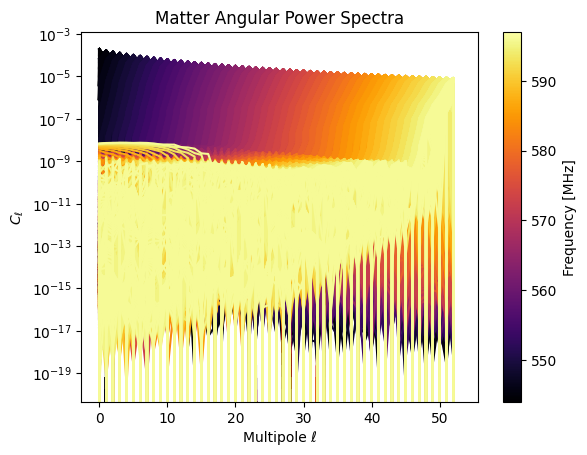

In [35]:
# Normalize for colormap
cmap = plt.get_cmap('inferno')
norm = plt.Normalize(freqs[:len(freqs)//10].min(), freqs[:len(freqs)//10].max())

fig, ax = plt.subplots()

for i, f in enumerate(freqs[:len(freqs)//10]):
    ax.plot(cls_full[i], color=cmap(norm(f)))

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy for older matplotlib versions
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Frequency [MHz]')

ax.set_yscale('log')
ax.set_xlabel('Multipole ℓ')
ax.set_ylabel(r'$C_\ell$')
ax.set_title('Matter Angular Power Spectra')

plt.show()

Extra Plots

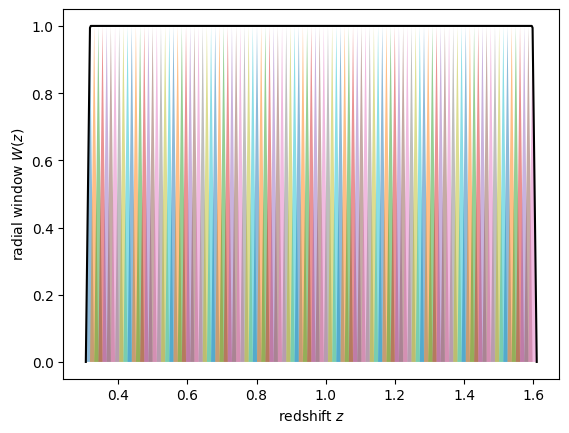

544 544


In [14]:
# plot the individual shells
for shell in shells:
    plt.fill_between(shell.za, np.zeros_like(shell.wa), shell.wa, alpha=0.5)

# plot the total of all shells
all_za = np.linspace(z_i, z_f, nfreqs)
all_wa = sum(np.interp(all_za, shell.za, shell.wa) for shell in shells)
plt.plot(all_za, all_wa, "-k")

plt.xlabel("redshift $z$")
plt.ylabel("radial window $W(z)$")
plt.show()
print(len(all_za), len(all_wa))